Generating the toy dataset to be phylogenetically curated as part of the course in [this]() notebook.

For demonstration purposes we are extracting a random subset of sequencing records (max 5 per species) and a set of records that we know are mislabelled from the full-scale curation process [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/tree/master/data/exercise-5/supplementary_data/reference_db).

In [1]:
from reprophylo import *

In [3]:
pj = Project('../../input_data/target_locus.csv', pickle='reduced_tree.pkl', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


Genbank formatted sequence records from full analyses after removal of redundancy.

In [4]:
pj.read_embl_genbank(['../../input_data/CytB_nr_pre_Sativa.gb'])

/home/reprophylo/reprophylo.py:1015: UserWarning: Version control off
  warnings.warn('Version control off')


In [5]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


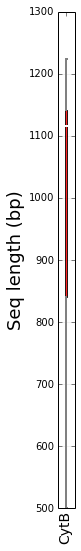

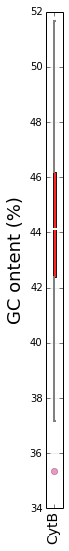

In [6]:
%matplotlib inline
pj.report_seq_stats()

Collect all record ids in a list.

In [7]:
full_id_list = []
for r in pj.records:
    full_id_list.append(r.id)
    
print len(full_id_list)

1760


Find the ids of the records which are mislabelled according to SATIVA.

In [9]:
rec_mislabelled = {}
sativa=open('../../input_data/CytB.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]

In [10]:
print rec_mislabelled

{'EU492281.1': '0.989', 'EU224046.1': '0.838', 'AJ969128.1': '0.999', 'AJ937943.1': '0.868', 'JF489783.1': '1.000', 'KT275288.1': '0.994', 'DQ185405.1': '1.000', 'KT275289.1': '0.998', 'EU224045.1': '0.819', 'JQ346141.1': '1.000', 'JQ661401.1': '1.000', 'AJ937931.1': '0.922', 'AJ937952.1': '0.791', 'AJ937925.1': '0.999', 'JQ661398.1': '0.973', 'AJ937951.1': '0.792', 'KP644340.1': '1.000', 'DQ664351.1': '0.587', 'GQ279764.1': '0.625', 'GU182336.1': '0.920', 'JQ661399.1': '0.974', 'KP452507.1': '0.508', 'JQ661400.1': '0.973', 'JQ231114.1': '1.000'}


Exclude the record ids that have been identified as mislabelled from the total list of ids to produce the pool from which random records will be drawn.

In [11]:
pool = []

for i in full_id_list:
    if not i in rec_mislabelled.keys():
        pool.append(i)
        
print len(pool)

1736


Bin records by species.

In [ ]:
species={}
count = 0
for r in pj.records:
    if r.id in pool:
        count+=1
        source = [f for f in r.features if f.type == 'source'][0]
        if not " ".join(source.qualifiers['organism'][0].split()[0:2]) in species:
            species[" ".join(source.qualifiers['organism'][0].split()[0:2])] = []
        species[" ".join(source.qualifiers['organism'][0].split()[0:2])].append(r.id)
        
total=len(species)

print "Total number of records: %i" %count
print "Number of species (see below for full list): %i" %len(species)
print species

For every species extract at most a total of 5 record ids.

In [13]:
import random

to_keep = []
for sp in species:
#    print sp
#    print len(species[sp])
    if len(species[sp]) > 5:
        to_keep.extend(random.sample(species[sp], 5))
    else:
        to_keep.extend(species[sp])
        

print len(to_keep)

274


Remove _Petromyzon marinus_ (Genbank accession: NC_001626.1) from the list of focal records for aesthetic reasons.

In [14]:
for i in range(len(to_keep)):
    if 'NC_001626.1' == to_keep[i]:
        del to_keep[i]
        break
print len(to_keep)

273


Add the mislabelled ids to the list.

In [15]:
to_keep.extend(rec_mislabelled.keys())
print len(to_keep)

297


Now that we've generated a random list of records, collect the ids of the remaining sequences in a list to be excluded from the analysis.

In [16]:
to_drop = {'CytB': []}

for s in full_id_list:
    if not s in to_keep:
        to_drop['CytB'].append(s)

print len(to_drop['CytB'])

1463


Write out the good records in Genbank format to be analysed with SATIVA.

In [18]:
seqs = []
from Bio import SeqIO
for r in pj.records:
    if r.id in to_keep:
        seqs.append(r)

out = open('CytB_nr_pre_Sativa.gb','w')
SeqIO.write(seqs, out, 'genbank')
out.close()

Exclude records from Reprophylo data set.

In [19]:
pj.exclude(start_from_max=False, **to_drop)

Configure alignment object.

In [20]:
mafft_linsi = AlnConf(pj,                              # The Project
                    method_name='mafftLinsi',        # Any unique method name,
                    CDSAlign=True,                   # Use this method to align
                    codontable=2,                    # The genetic code that
                    program_name='mafft',            # mafft or muscle.
                    cmd='mafft',                     # The command on your machine
                    loci=['CytB'],                 # A list of loci names to align.vel.
                    cline_args={'localpair': True,# Program specific keywords and arguments.
                                'maxiterate': 1000}# cine_args=={} by default, which will
                    )

mafft --localpair --maxiterate 1000 428121473691046.2_CDS_proteins_CytB.fasta


Perform alignment.

In [21]:
pj.align([mafft_linsi])

In [22]:
pj.write_alns(id=['record_id','source_organism'], format='fasta')

['CytB@mafftLinsi_aln.fasta']

Determine custom clipping points in alignment.

In [23]:
import numpy as np

per_col=[]

aln = pj.fa('CytB@mafftLinsi')


icol=0
for a in aln[1,:]:
    ACGT_count=0
    col=aln[:,icol]
    for i in range(len(col)):
        if col[i] in ['A','G','C','T']:
            ACGT_count+=1
#    print pj.fa('CytB@mafftLinsi')[:,a]
    per_col.append(float(ACGT_count)/len(col))
    icol+=1

wsize=10
min_prop=0.7
    
print "\nFinding forward clip position:\n"
forw_count=0
forw_clip=0
for i in range(len(per_col)-wsize):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        forw_count+=1
        forw_clip=i
        print forw_count,i,np.mean(per_col[i:i+wsize])
    else:
        forw_count=0
        
    if forw_count >= wsize:
        break
        
print "Suggested forward clip at: %s (%s,%s)" %(forw_clip-wsize,forw_count,forw_clip)

print "\nFinding reverse clip position:\n"
reve_count=0
reve_clip=0
for i in reversed(range(len(per_col)-wsize)):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        reve_count+=1
        reve_clip=i
        print reve_count,i,np.mean(per_col[i:i+wsize])
    else:
        reve_count=0
        
    if reve_count >= wsize:
        break
    
print "Suggested reverse clip at: %s (%s,%s)" %(reve_clip+wsize,reve_count,reve_clip)

returning alignment object CytB@mafftLinsi

Finding forward clip position:

1 26 0.700673400673
2 27 0.776767676768
3 28 0.783838383838
4 29 0.790909090909
5 30 0.799326599327
6 31 0.805050505051
7 32 0.810774410774
8 33 0.818855218855
9 34 0.824915824916
10 35 0.830976430976
Suggested forward clip at: 25 (10,35)

Finding reverse clip position:

1 1145 0.701346801347
2 1144 0.705723905724
3 1143 0.710101010101
4 1142 0.714478114478
5 1141 0.715488215488
6 1140 0.716498316498
7 1139 0.717508417508
8 1138 0.718518518519
9 1137 0.719528619529
10 1136 0.720538720539
Suggested reverse clip at: 1146 (10,1136)


Clip Alignment using Biopython.

In [24]:
from Bio import AlignIO

aln = pj.fa('CytB@mafftLinsi')

clipped_aln = aln[:,forw_clip-wsize:reve_clip+wsize]

returning alignment object CytB@mafftLinsi


Convert the clipped alignemnt (which is a Biopython alignment object) to a ReproPhylo trimmed alignment object, so that we can resume working with it in ReproPhylo.

In [25]:
pj.trimmed_alignments["CytB@mafftLinsi_aln_clipped"] = clipped_aln

Write clipped alignment to file for downstream taxonomic curation using SATIVA.


In [26]:
from Bio import AlignIO

out=open('CytB@mafftLinsi_aln_clipped.phy', 'w')
AlignIO.write(clipped_aln, out, 'phylip-relaxed')
out.close()

Configure tree inference method - RaxML.

In [27]:
raxml = RaxmlConf(pj, method_name='raxml-mafftLinsi-clipped', 
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['CytB@mafftLinsi_aln_clipped'],
                 model='GAMMA',
                 threads=5,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 431761473691128.36_CytB@mafftLinsi_aln_clipped0 -p 553 -s 431761473691128.36_CytB@mafftLinsi_aln_clipped.fasta -T 5 -x 372 -N 100


Infer Maximum likelihood tree.

In [28]:
pj.tree([raxml])

In [29]:
print pj.used_methods['raxml-mafftLinsi-clipped']

RaxmlConf named raxml-mafftLinsi-clipped with ID 431761473691128.36
Alignments: CytB@mafftLinsi_aln_clipped 
Created on: Mon Sep 12 14:38:48 2016
Commands:
CytB@mafftLinsi_aln_clipped:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 431761473691128.36_CytB@mafftLinsi_aln_clipped0 -p 553 -s 431761473691128.36_CytB@mafftLinsi_aln_clipped.fasta -T 5 -x 372 -N 100

Environment:
Platform: Linux-3.13.0-54-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: chrishah-office
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.
execution time:
2039.5449481

Core Methods section sentenc

In [30]:
pickle_pj(pj, 'reduced_tree.pkl')

'reduced_tree.pkl'

Now let's visualize the tree.

Prepare tree annotation:
 - define outgroups
 - specify support coloration

In [31]:
pj.add_qualifier_from_source('organism')

In [32]:
for species in ['Lampetra']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [33]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [34]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=50, scale=500,
            html='mafftLinsi-clipped-raxml.html')

Create a static image of the final tree.

In [35]:
%%bash

last_png=$(ls -hlrt *CytB@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png CytB_mafftLinsi_clipped_raxml_dirty_multifurc50.png

Alternative formatting of tree.

In [36]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=None, scale=500,
            html='mafftLinsi-clipped-raxml.html')

In [37]:
%%bash

last_png=$(ls -hlrt *CytB@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png CytB_mafftLinsi_clipped_raxml_dirty_multifurcNone.png

We move to running SATIVA at this stage to identify putatively mislabelled sequencing records.


##============================================##

__Run SATIVA__ see notebook [here]().

##============================================##


After we have run SATIVA on the alignment that we produced above.

Now we are going to highlight the records that SATIVA considers mislabelled in the tree. We are also going to add a heatmap to the tree illustrating the confidence that SATIVA has in a given call.
Parse SATIVA output and record putatively mislabelled sequence records and the confidence of the call.

Annotate tree with SATIVA results.

In [38]:
rec_mislabelled = {}
sativa=open('../run_SATIVA/CytB.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]
        

Add two new qualifiers containing info about he SATIVA results to the sequence features.

In [39]:
for r in pj.records:
    if r.id in rec_mislabelled:
        for f in r.features:
            f.qualifiers['mislabeled'] = ['yes']
            f.qualifiers['mislabeled_conf'] = [rec_mislabelled[r.id]]
    else:
        for f in r.features:
            f.qualifiers['mislabeled'] = ['no']
            f.qualifiers['mislabeled_conf'] = [0.0001]

In [40]:
pj.propagate_metadata()

Prepare tree annotation:

 - color records that were identified by SATIVA as being mislabelled.
 - add heatmap with mislabel confidence

In [41]:
leaf_colors = {'yes':'red', 'no': 'black'}

In [43]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='mafftLinsi-clipped-raxml-SATIVA.html',
            fsize=13, scale=500,
            heat_map_meta = ['mislabeled_conf'], heat_map_colour_scheme = 1,
            leaf_node_color_meta = 'mislabeled', leaf_label_colors = leaf_colors)

Create static image of final annoated tree.

In [44]:
%%bash

last_png=$(ls -hlrt *CytB@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png CytB_mafftLinsi_clipped_raxml_SATIVA_annotated.png